Name: Pranay Jain \
Roll number: AI22BTECH11020

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Problem 1: Perceptron Learning Algorithm

In [2]:
class PerceptronLearning:
        
    def __init__(self, gamma, number_of_points):
        
        self.gamma = gamma # Margin of the classifier (level of separability)
        self.number_of_points = number_of_points # Number of points in each category
        self.positive_samples = []
        self.negative_samples = []
    
    # Randomly generates a 2D linearly separable dataset with separation gamma
    def generate_dataset(self):
        
        standard_deviation = 5 * self.gamma # Standard deviation of the distribution of the randomly generated inputs
        positive_count = 0
        negative_count = 0
        self.positive_samples = []
        self.negative_samples = []
        
        weights = np.random.rand(3) # True classifier (including the bias term)
        weights /= np.linalg.norm(weights) # Normalizing the weight vector
        
        # Keep generating points until both categories have at least number_of_points samples
        while positive_count < self.number_of_points or negative_count < self.number_of_points:
            
                x = np.random.randn(2) * standard_deviation # Mean is at the origin
                x = np.array([x[0], x[1], 1]) # Appending 1 to the sample for multiplication with the bias term
                
                if x @ weights > self.gamma:
                    self.positive_samples.append(np.array([x[0], x[1], 1])) # Appending the label to the sample
                    positive_count += 1
                    
                elif x @ weights < - self.gamma:
                    self.negative_samples.append(np.array([x[0], x[1], -1])) # Appending the label to the sample
                    negative_count += 1
                    
        return self.positive_samples, self.negative_samples
    
    # Performs perceptron training algorithm for a maximum number of max_epochs epochs
    def train(self, max_epochs):
        
        weights = np.zeros(3) # Initial weights
        dataset = self.positive_samples + self.negative_samples # Concatenating both positive and negative samples
        np.random.shuffle(dataset) # Shuffling the dataset 
        iterations = 0 # Total number of iterations (changes to weights) required until convergence
        
        # Keep iterating through the dataset until all points are correctly classified
        for epoch in range(max_epochs):
            
            misclassifications = 0
            
            for data in dataset:
                x = np.array([data[0], data[1], 1]) # Input concatenated with 1
                y = data[2] # Label corresponding to input
                
                if y * (weights @ x) <= 0: # The input was misclassified
                    misclassifications += 1
                    iterations += 1
                    weights += y * x
               
            if not misclassifications: # All inputs are correctly classified
                break
                
        return weights, iterations

### Generating and plotting the dataset

Text(0.5, 1.0, 'Dataset')

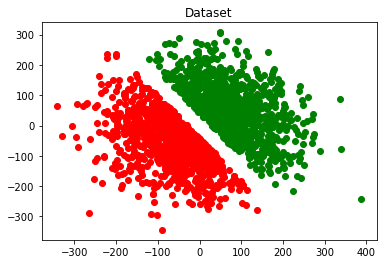

In [3]:
perceptron = PerceptronLearning(20, 1000)
pos, neg = perceptron.generate_dataset()

plt.scatter([x[0] for x in pos], [x[1] for x in pos], color='g')
plt.scatter([x[0] for x in neg], [x[1] for x in neg], color='r')
plt.title('Dataset')

This is what the linearly separable training dataset looks like 

The green points represent positive samples with label $1$ and the red points represent negative samples with label $-1$

### Training the classifier

11


Text(0.5, 1.0, 'Trained Perceptron Classifier')

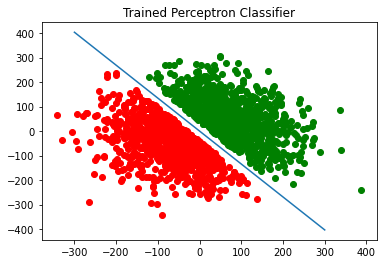

In [4]:
W, iters = perceptron.train(1000)
X = np.linspace(-300, 300, 100)
Y = - (W[0] / W[1]) * X - (W[2] / W[1]) # Equation of the line is W[0]*X + W[1]*Y + W[2] = 0
print(iters)

plt.plot(X, Y)
plt.scatter([x[0] for x in pos], [x[1] for x in pos], color='g')
plt.scatter([x[0] for x in neg], [x[1] for x in neg], color='r')
plt.title('Trained Perceptron Classifier')

We can see that the obtained classifier is able to perfectly classify the dataset in $11$ iterations

### Analysis of margin vs iterations

Text(0.5, 1.0, 'Average number of iterations vs level of separability')

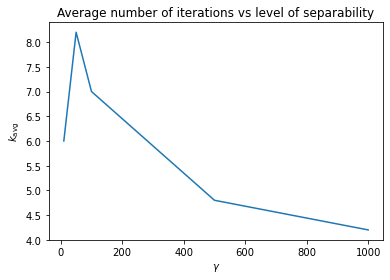

In [5]:
gammas = [10, 50, 100, 500, 1000] # Values of gamma for testing
K = [] # List to store the average number of iterations required for each gamma

for gamma in gammas:
    perceptron = PerceptronLearning(gamma, 1000)
    total_iters = 0
    
    for i in range(5): # 5 times for each value of gamma
        pos, neg = perceptron.generate_dataset()
        _, iters = perceptron.train(1000)
        total_iters += iters
        
    K.append(total_iters / 5) # Average number of iterations requried
    
plt.plot(gammas, K)
plt.xlabel('$\gamma$')
plt.ylabel('$k_{\mathrm{avg}}$')
plt.title('Average number of iterations vs level of separability')

We can observe that as the level of separability increases, we require less number of iterations for perfect classification on average, which makes sense because the farther apart the dataset, the easier it is to classify it

The plot is also in line with the theoretical upper bound on $k$
$$k_{\max} \propto \frac{1}{\gamma^2}$$

## Problem 2: Gradient Descent

### Loss formulation

Regular 0-1 loss is not even continuous and hinge loss is not differentiable, so they cannot be used for gradient descent

Alternatively, we can use a smoothened version of hinge loss \
Regular hinge loss is given by
$$ l(y, \mathbf{w}, \mathbf{x}) = \max(0, 1 - y \mathbf{w}^\top \mathbf{x}) $$

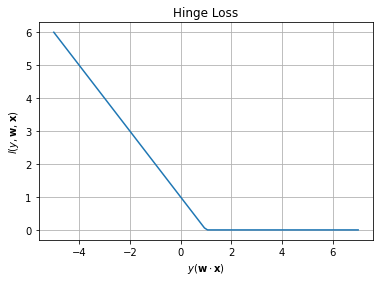

In [6]:
# Plotting hinge loss
def hinge_loss(t):
    return max(0, 1 - t)

# Vectorize the loss function so that it can be applied to an array
hinge_loss_vec = np.vectorize(hinge_loss) 

T = np.linspace(-5, 7, 100)
plt.plot(T, hinge_loss_vec(T))
plt.xlabel('$y (\mathbf{w} \cdot \mathbf{x}) $')
plt.ylabel('$l(y, \mathbf{w}, \mathbf{x})$')
plt.title('Hinge Loss')
plt.grid()

There is non-differentiability at the point where it meets the $x$-axis \
We can keep the same hinge loss for $x < 0$ and introduce a quadratic approximation that smoothens the part between the points $(0,1)$ and the intersection with the $x$-axis, call it $(r, 0)$. Beyond $x = r$, the loss is $0$

Let the quadratic function be $f(t) = at^2 + bt + c$ where $t = y \mathbf{w}^\top \mathbf{x}$
$$ \begin{align}
f(0) = 1 &\implies c = 1 && (\text{continuity at } x = 0) \\
f'(0) = -1 &\implies b = -1 && (\text{differentiablity at } x = 0) \\
f(r) = 0 &\implies ar^2 + br + c = ar^2 - r + 1 = 0 && (\text{continuity at } x = r) \\
f'(r) = 0 &\implies 2ar + b = 2ar - 1 = 0  && (\text{differentiablity at } x = r) \\ 
\end{align} $$

On solving the equations, we get
$$ \begin{align} 
&r = \frac{1}{2a}  \\
\implies &a \cdot \frac{1}{4a^2} - \frac{1}{2a} + 1 = 0 \\
\implies &\frac{1}{4a} = 1 \\
\implies &a = \frac{1}{4} \\
\implies &r = \frac{1}{2a} = 2
\end{align} $$

Therefore, our smoothened loss function is given by
$$ l(t) =
\begin{cases}
    1 - t & t < 0 \\
    \frac{t^2}{4} - t + 1 & 0 \le t \le 2 \\
    0 & t > 2
\end{cases} $$
where $t = y \mathbf{w}^\top \mathbf{x}$

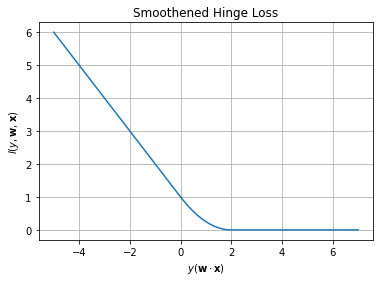

In [7]:
# Plotting the smoothened loss function
def smooth_loss(t):
    if t < 0:
        return 1 - t
    elif t <= 2:
        return t**2/4 - t + 1
    else:
        return 0
    
# Vectorize the loss function so that it can be applied to an array
smooth_loss_vec = np.vectorize(smooth_loss) 

T = np.linspace(-5, 7, 100)
plt.plot(T, smooth_loss_vec(T))
plt.xlabel('$y (\mathbf{w} \cdot \mathbf{x}) $')
plt.ylabel('$l(y, \mathbf{w}, \mathbf{x})$')
plt.title('Smoothened Hinge Loss')
plt.grid()

This does satisfy the properties of an ideal loss function for classification \
When $y$ and $\mathbf{w}^\top \mathbf{x}$ are of the same sign, the loss is low and even zero when the product is sufficiently high \
When they are of opposite signs, the loss is high and penalty is higher for a more negative product

### Gradient computation and update equation

The derivative of the loss function is given by
$$ l'(t) =
\begin{cases}
-1 & t < 0 \\
\frac{t}{2} - 1 & 0 \le t \le 2 \\
0 & t > 2
\end{cases} $$

If the size of the training dataset is $m$, then the optimization problem at hand is
$$ \arg\min_{\mathbf{w}}  \frac{1}{m} \sum_{i=1}^m l(y_i, \mathbf{w}, \mathbf{x}_i) $$

The weight vector is of the form $\mathbf{w} = \begin{pmatrix} w_1 & w_2 & b \end{pmatrix}^\top $ and the inputs are of the form $\mathbf{x}_i = \begin{pmatrix} x_{i1} & x_{i2} & 1 \end{pmatrix}^\top $, i.e.,
$$ \mathbf{w}^\top \mathbf{x}_i = w_1 x_{i1} + w_2 x_{i2} + b $$

The gradient of the loss function with respect to $\mathbf{w}$ is then given by
$$ \begin{align}
\frac{\partial l(y_i, \mathbf{w}, \mathbf{x}_i)}{\partial w_1} &= \frac{\partial l(t)}{\partial t} \frac{\partial t}{\partial w_1} = l'(t) y_i x_{i1} \\
\frac{\partial l(y_i, \mathbf{w}, \mathbf{x}_i)}{\partial w_2} &= \frac{\partial l(t)}{\partial t} \frac{\partial t}{\partial w_2} = l'(t) y_i x_{i2} \\
\frac{\partial l(y_i, \mathbf{w}, \mathbf{x}_i)}{\partial b} &= \frac{\partial l(t)}{\partial t} \frac{\partial t}{\partial b} = l'(t) y_i \\
\implies \nabla_{\mathbf{w}} l(y_i, \mathbf{w}, \mathbf{x}_i) &= \begin{pmatrix} \frac{\partial l(y_i, \mathbf{w}, \mathbf{x}_i)}{\partial w_1} & \frac{\partial l(y_i, \mathbf{w}, \mathbf{x}_i)}{\partial w_2} & \frac{\partial l(y_i, \mathbf{w}, \mathbf{x}_i)}{\partial b} \end{pmatrix}^\top \\
&= l'(t) \begin{pmatrix} y_i x_{i1} & y_i x_{i2} & y_i \end{pmatrix}^\top
\end{align} $$

Thus, the gradient of the total loss of the entire dataset is given by
$$ \nabla_{\mathbf{w}} l(\mathbf{w}, \mathcal{D}) = \frac{1}{m} \sum_{i=1}^m l'(y_i \mathbf{w}^\top \mathbf{x}_i) \begin{pmatrix} y_i x_{i1} & y_i x_{i2} & y_i \end{pmatrix}^\top $$

In [8]:
# Derivative of the loss function
def loss_derivative(t):
    if t < 0:
        return -1
    elif t <= 2:
        return t/2 - 1
    else:
        return 0

In [9]:
class GradientDescent:
    
    def __init__(self, iterations, learning_rate, dataset):
        
        self.iterations = iterations # Number of iterations to run gradient descent for
        self.learning_rate = learning_rate # Learning rate in the update equation
        self.dataset = dataset # Training dataset
        
    # Computes the gradient of the total loss over the entire dataset    
    def compute_gradient(self, weights):
        
        total_gradient = np.zeros(3)
        m = len(self.dataset)
        
        for data in self.dataset:
            
            x = np.array([data[0], data[1], 1]) # Appending 1 to input for multiplication with bias
            y = data[2] # Label        
            t = y * (weights @ x)
            
            dl = loss_derivative(t) # l'(t)
            dt = np.array([y * x[0], y * x[1], y]) # (dt/dw1, dt/dw2, dt/db)
            
            total_gradient += dl * dt
            
        return total_gradient / m
    
    # Performs gradient descent iterations number of times
    def gradient_descent(self):
        
        weights = np.random.rand(3) # Initial weights
        
        for _ in range(self.iterations):
            grad = self.compute_gradient(weights)
            weights -= self.learning_rate * grad # Update equation
            
        return weights

### Training the classifier

Text(0.5, 1.0, 'Dataset Before Training')

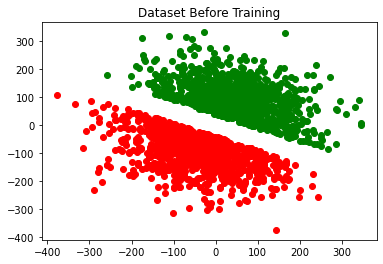

In [10]:
# Generate random training dataset
perceptron = PerceptronLearning(20, 1000)
pos, neg = perceptron.generate_dataset()
dataset = pos + neg
np.random.shuffle(dataset)

plt.scatter([x[0] for x in pos], [x[1] for x in pos], color='g')
plt.scatter([x[0] for x in neg], [x[1] for x in neg], color='r')
plt.title('Dataset Before Training')

Text(0.5, 1.0, 'Gradient Descent Trained Classifier')

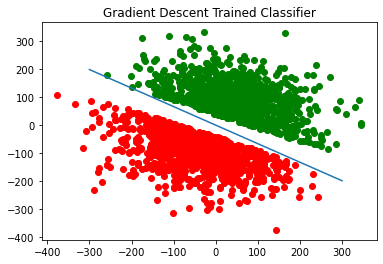

In [11]:
classifier = GradientDescent(1000, 0.01, dataset)
W = classifier.gradient_descent()
X = np.linspace(-300, 300, 100)
Y = - (W[0] / W[1]) * X - (W[2] / W[1]) # Equation of the line is W[0]*X + W[1]*Y + W[2] = 0

plt.plot(X, Y)
plt.scatter([x[0] for x in pos], [x[1] for x in pos], color='g')
plt.scatter([x[0] for x in neg], [x[1] for x in neg], color='r')
plt.title('Gradient Descent Trained Classifier')

We can observe that gradient descent has produced a perfect classifier for the training data

## Problem 3: Multilayer Perceptron

In [12]:
class MLPNetwork:
    
    def __init__(self, hidden_layer):
        
        # Number of neurons in each layer
        self.input_layer = 2
        self.hidden_layer = hidden_layer
        self.output_layer = 1
        
        # Weight matrices between the layers
        self.input_hidden_weights = np.zeros((self.hidden_layer, self.input_layer))
        self.hidden_output_weights = np.zeros((self.output_layer, self.hidden_layer))
        
        # Bias terms for each layer
        self.hidden_bias = 0
        self.output_bias = 0
        
        # Node values present at each neuron
        self.hidden_values = np.zeros(self.hidden_layer)
        self.output_values = np.zeros(self.output_layer)
        
        # Stores the training loss at each epoch
        self.loss_per_epoch = []
        
    # Randomly generates a 2D non-linearly separable dataset
    def generate_dataset(self, inner_radius, outer_radius, number_of_points):
        
        positive_samples = []
        negative_samples = []
        
        # Generate number_of_points samples for each category
        for _ in range(number_of_points):
            
            x = np.random.rand(2) * 2 - 1 # Generate in the range [-1, 1]
            # Make the norm of x equal to outer_radius
            x = outer_radius * (x / np.linalg.norm(x))
            x += np.random.randn() # Add Gaussian noise 
            positive_samples.append(np.array([x[0], x[1], 1])) # Appending the label of the sample to itself
        
            x = np.random.rand(2) * 2 - 1 # Generate in the range [-1, 1]
            # Make the norm of x equal to inner_radius
            x = inner_radius * (x / np.linalg.norm(x))
            x += np.random.randn() # Add Gaussian noise 
            negative_samples.append(np.array([x[0], x[1], -1])) # Appending the label of the sample to itself
            
        return positive_samples, negative_samples
    
    # Initialize the weights of the network to random numbers
    def initialize_weights(self):
        
        self.input_hidden_weights = np.random.rand(self.hidden_layer, self.input_layer)
        self.hidden_output_weights = np.random.rand(self.output_layer, self.hidden_layer)
        self.hidden_bias = np.random.rand()
        self.output_bias = np.random.rand()
        return self.input_hidden_weights, self.hidden_output_weights, self.hidden_bias, self.output_bias
    
    # Activation function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Derivative of the activation function
    def sigmoid_derivative(self, x):
        return np.exp(-x) / (1 + np.exp(-x))**2
    
    # Compute training loss for the entire dataset
    def compute_loss(self, dataset):
        
        m = len(dataset)
        loss = 0
        
        for data in dataset:
            y = data[2] # Label
            out = self.forward_pass(data)
            t = y * out
            loss += smooth_loss(t) # Add loss of each point in the dataset
            
        return loss / m
    
    # Populating the node values at each neuron in a forward pass
    def forward_pass(self, x):
        
        x = np.array([x[0], x[1]])
        
        for i in range(self.hidden_layer):
            result = x @ self.input_hidden_weights[i] + self.hidden_bias
            result = self.sigmoid(result)
            self.hidden_values[i] = result
            
        for i in range(self.output_layer):
            result = self.hidden_values @ self.hidden_output_weights[i] + self.output_bias
            result = self.sigmoid(result)
            self.output_values[i] = result
            
        return self.output_values[0] # Only one neuron in the output layer
    
    # Backpropagation to find all the gradients
    def backpropagation(self, data):
        
        # Initializing gradients of the loss with respect to the weights to zero
        input_hidden_gradients = np.zeros((self.hidden_layer, self.input_layer))
        hidden_output_gradients = np.zeros((self.output_layer, self.hidden_layer))
        
        # Initializing gradients of the loss with respect to the biases to zero
        hidden_bias_gradient = 0
        output_bias_gradient = 0
        
        x = np.array([data[0], data[1]])
        y = data[2] # Label
        out = self.forward_pass(data)
        t = y * out
        
        dl = loss_derivative(t) * y 
        dt = self.sigmoid_derivative(self.hidden_values @ self.hidden_output_weights[0] + self.output_bias)
        
        # Computing gradients with respect to the weights and bias in the last layer
        for i in range(self.hidden_layer):
            hidden_output_gradients[0, i] = dl * dt * self.hidden_values[i]        
        output_bias_gradient = dl * dt
        
        # Computing gradients with respect to the weights and bias in the last layer
        for i in range(self.hidden_layer):
            
            dh = self.sigmoid_derivative(x @ self.input_hidden_weights[i] + self.hidden_bias)
            
            for j in range(self.input_layer):
                input_hidden_gradients[i, j] = dl * dt * self.hidden_output_weights[0, i] * dh * x[j]
                
            hidden_bias_gradient += dl * dt * self.hidden_output_weights[0, i] * dh 
            
        return input_hidden_gradients, hidden_output_gradients, hidden_bias_gradient, output_bias_gradient
    
    # Performing gradient descent to update the weights of the network
    def gradient_descent(self, epochs, learning_rate, dataset):
        
        self.loss_per_epoch = []
        
        for _ in range(epochs):
            
            # For each sample in the dataset one-by-one
            for data in dataset:
                
                # Compute gradients
                ih_grad, ho_grad, hb_grad, ob_grad = self.backpropagation(data) 
                
                # Update weights and biases
                self.input_hidden_weights -= learning_rate * ih_grad
                self.hidden_output_weights -= learning_rate * ho_grad
                self.hidden_bias -= learning_rate * hb_grad
                self.output_bias -= learning_rate * ob_grad
                
            training_loss =  self.compute_loss(dataset)
            self.loss_per_epoch.append(training_loss)
                
        return self.input_hidden_weights, self.hidden_output_weights, self.hidden_bias, self.output_bias
    
    # Predicts the label of a given input
    def predict(self, data):
        
        out = self.forward_pass(data) # This output is sigmoidal
        # Sigmoidal output is thresholded at 0.5
        if out > 0.5:
            return 1
        else:
            return -1

### Explanation of gradient computation

Let us use the notation discussed in class \
$w^{(l)}_{ji}$ is the weight of edge between neuron $j$ in layer $l$ and neuron $i$ in layer $l-1$ \
$b^{(l)}$ is the bias for later $l$ (assuming same bias for one whole layer) \
$s^{(l)}_j$ is the weighted input to neuron $j$ in layer $l$ \
$x^{(l)}_j$ is the activated output at neuron $j$ in layer $l$ \
$y$ is the true label for the input $\mathbf{x}^{(0)}$

Indexing the input, hidden and output layers as $0, 1$ and $2$ respectively, we have
$$ \begin{align}
s^{(1)}_j &= \sum_k w^{(1)}_{jk} x^{(0)}_k + b^{(1)} \\
x^{(1)}_j &= \sigma\left(s^{(1)}_j\right) \\
s^{(2)}_0 &= \sum_j w^{(2)}_{0j} x^{(1)}_j + b^{(2)} \qquad (\text{only one neuron in the output layer, indexed by } 0) \\
x^{(2)}_0 &= \sigma\left(s^{(2)}_0\right) \\
\mathcal{L} &= l(y x^{(2)}_0) 
\end{align} $$

Thus, the gradients are given by
$$ \begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(2)}_{0j}} 
&= \frac{\partial \mathcal{L}}{\partial \left(y x^{(2)}_0\right)}
\frac{\partial \left(y x^{(2)}_0\right)}{\partial x^{(2)}_0}
\frac{\partial x^{(2)}_0}{\partial s^{(2)}_0}
\frac{\partial s^{(2)}_0}{\partial w^{(2)}_{0j}} \\
&= l'(y x^{(2)}_0) \cdot y \cdot \sigma'\left(s^{(2)}_0\right) \cdot x^{(1)}_j \\
\frac{\partial \mathcal{L}}{\partial b^{(2)}} 
&= \frac{\partial \mathcal{L}}{\partial \left(y x^{(2)}_0\right)}
\frac{\partial \left(y x^{(2)}_0\right)}{\partial x^{(2)}_0}
\frac{\partial x^{(2)}_0}{\partial s^{(2)}_0}
\frac{\partial s^{(2)}_0}{\partial b^{(2)}} \\
&= l'(y x^{(2)}_0) \cdot y \cdot \sigma'\left(s^{(2)}_0\right) \cdot 1 
\end{align} $$

In the code, $l'(y x^{(2)}_0) \cdot y$ is stored in the variable `dl` \
$\sigma'\left(s^{(2)}_0\right)$ is stored in `dt` \
`self.hidden_values[j]` represents $x^{(1)}_j$

Now, for the other gradients
$$ \begin{align}
\frac{\partial \mathcal{L}}{\partial w^{(1)}_{jk}} 
&= \frac{\partial \mathcal{L}}{\partial \left(y x^{(2)}_0\right)}
\frac{\partial \left(y x^{(2)}_0\right)}{\partial x^{(2)}_0}
\frac{\partial x^{(2)}_0}{\partial s^{(2)}_0}
\frac{\partial s^{(2)}_0}{\partial x^{(1)}_j}
\frac{\partial x^{(1)}_j}{\partial s^{(1)}_j}
\frac{\partial s^{(1)}_j}{\partial w^{(1)}_{jk}} \\
&= l'(y x^{(2)}_0) \cdot y \cdot \sigma'\left(s^{(2)}_0\right) \cdot w^{(2)}_{0j} \cdot \sigma'\left(s^{(1)}_j\right) \cdot x^{(0)}_k \\
\frac{\partial \mathcal{L}}{\partial b^{(1)}} 
&= \frac{\partial \mathcal{L}}{\partial \left(y x^{(2)}_0\right)}
\frac{\partial \left(y x^{(2)}_0\right)}{\partial x^{(2)}_0}
\frac{\partial x^{(2)}_0}{\partial s^{(2)}_0}
\frac{\partial s^{(2)}_0}{\partial x^{(1)}_j}
\frac{\partial x^{(1)}_j}{\partial s^{(1)}_j}
\frac{\partial s^{(1)}_j}{\partial b^{(1)}} \\
&= l'(y x^{(2)}_0) \cdot y \cdot \sigma'\left(s^{(2)}_0\right) \cdot w^{(2)}_{0j} \cdot \sigma'\left(s^{(1)}_j\right) \cdot 1
\end{align} $$

`self.hidden_output_weights[0, j]` represents $w^{(2)}_{0j}$ \
$\sigma'\left(s^{(1)}_j\right)$ is stored in the variable `dh` \
`x[k]` represents $x^{(0)}_k$

### Generating and plotting the dataset

Text(0.5, 1.0, 'Training Dataset')

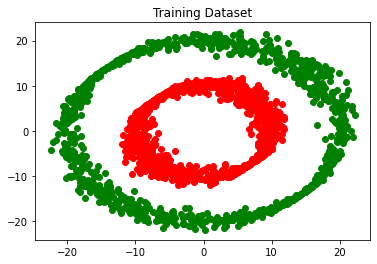

In [13]:
net = MLPNetwork(3)
pos, neg = net.generate_dataset(10, 20, 1000)

plt.scatter([x[0] for x in pos], [x[1] for x in pos], color='g')
plt.scatter([x[0] for x in neg], [x[1] for x in neg], color='r')
plt.title('Training Dataset')

### MLP definition

In [14]:
# Defining an MLP with 2 input neurons, 3 hidden layer neurons and 1 output neuron
net = MLPNetwork(3)

# Initializing and printing the weights and biases of the network
ih_weights, ho_weights, h_bias, o_bias = net.initialize_weights()
print(ih_weights)
print(h_bias)
print()
print(ho_weights)
print(o_bias)

[[0.80984173 0.4047319 ]
 [0.80552519 0.77989703]
 [0.96583663 0.6019379 ]]
0.6391108949155364

[[0.26135024 0.05659084 0.76961304]]
0.7530460941319093


In [15]:
# Testing forward pass of the network
net.initialize_weights()
pos, neg = net.generate_dataset(10, 20, 1000)
sample_input = pos[0]
print(sample_input)
net.forward_pass(sample_input)

[ 4.2818046  20.23779775  1.        ]


0.7369560289317277

In [16]:
# Testing backpropagation of the network
net.initialize_weights()
pos, neg = net.generate_dataset(10, 20, 1000)
sample_input = neg[0]
print(sample_input)
net.backpropagation(sample_input)

[ 8.79930319  4.85709392 -1.        ]


(array([[8.13801221e-07, 4.49207043e-07],
        [1.42069552e-05, 7.84204317e-06],
        [1.14780863e-05, 6.33574520e-06]]),
 array([[0.11012095, 0.11011148, 0.11011339]]),
 3.0114705741238714e-06,
 0.11012107305361188)

### Training the neural network

In [17]:
net = MLPNetwork(5)
net.initialize_weights()

pos, neg = net.generate_dataset(10, 20, 1000)
dataset = pos + neg
np.random.shuffle(dataset)

net.gradient_descent(300, 0.01, dataset)

(array([[-1.42183225, -0.27553396],
        [ 0.25487662,  1.2836165 ],
        [-0.00612566, -0.0055842 ],
        [-0.00609718, -0.00566165],
        [ 0.98868717, -1.0345933 ]]),
 array([[-10.89489769, -10.84614327,   9.51352989,   9.44939503,
         -11.12946556]]),
 15.118555805754196,
 7.4226249946322715)

The above cell takes roughly 1 minute 

### Testing the network

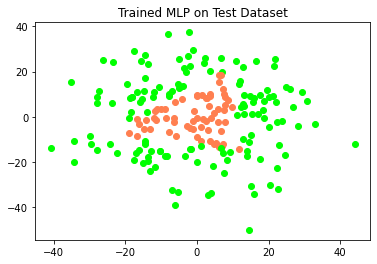

In [18]:
for _ in range(200):
    
    # Generating new test data point randomly
    x = np.random.randn(2) * 15
    
    # Passing the input through the network to obtain a prediction
    if net.predict(x) == 1:
        plt.scatter([x[0]], [x[1]], color='lime')
    else:
        plt.scatter([x[0]], [x[1]], color='coral')
        
    plt.title('Trained MLP on Test Dataset')

We can see that the MLP network has correctly learned the pattern present in the training data and is able to classify new test data points just like we wanted

### Plotting the training loss

Text(0.5, 1.0, 'Training Loss at each Epoch')

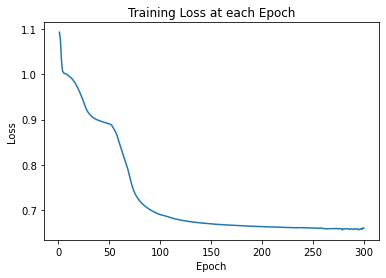

In [19]:
L = net.loss_per_epoch
N = len(L)

plt.plot(range(1, N + 1), L)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss at each Epoch')

As expected, the training loss decreases sharply as the number of epochs increases